In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm

from tidegauge_functions import calc_OLS_tides
import matplotlib.dates as mdates
from tidegauge_functions import read_tidegauge_psmsl
from tidegauge_functions import find_skiprows_startofline
from tidegauge_functions import read_tidegauge_monthly
%matplotlib inline

In [2]:
path = os.walk("data/tidegauge")
totalLoops = 0 

for root, directories, files in path:
    for directory in directories:
        print(directory)
    for file in files:
        tideName = files           #Fills the indices of the array with file names.
        totalLoops = totalLoops + 1 #Counts how many iterations the for loop completed.
        tideArray = files             #Creates the amount of indices needed for this array.

.ipynb_checkpoints


In [14]:
def para(df):
    paraDf = df['SSH'].resample('MS').mean()

    # The term bfill means that we use the value before filling in missing values
    paraDf = paraDf.fillna(paraDf.bfill())
    
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
    
    warnings.filterwarnings("ignore") # specify to ignore warning messages    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(paraDf,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

                results = mod.fit()

                print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    

In [15]:
def arima(df, totalSteps, param, param_seasonal):  
    
    #The 'MS' string groups the data in buckets by start of the month
    arimaDf = df['SSH'].resample('MS').mean()

    #The term bfill means that we use the value before filling in missing values
    arimaDf = arimaDf.fillna(arimaDf.bfill())

    mod = sm.tsa.statespace.SARIMAX(arimaDf,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)                      
    results = mod.fit()

    # Get forecast 500 steps ahead in future
    pred_uc = results.get_forecast(steps= totalSteps)

    # Get confidence intervals of forecasts
    pred_ci = pred_uc.conf_int()
    
    ax = arimaDf.plot(label='observed', figsize=(20, 15))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel('SSH')

    plt.legend()
    plt.show()
    
    return

In [3]:
def test_read_CCAR_altimetry(ccar_file):
    i_skip = find_skiprows_startofline(ccar_file, 'time')
    column_names=['Year', 'SSH', '', 'Year2', 'SSH_tides']
    df = pd.read_csv(ccar_file, 
                     skiprows=i_skip,
                     header=None, 
                     delimiter=',', 
                     names=column_names)
    
    # NaNs
#     df['SSH'] = df['SSH'].replace(-99999, np.nan) 
    
    ## Datetime operations
    year = df['Year'].astype(int)
    doy = ((df['Year'] - year) * 365).astype(int) + 1  # TODO: This might be off by one day...
    dt = pd.to_datetime(year.astype(str) + doy.astype(str), format='%Y%j')
    df = df.rename(columns={'Year': 'YearDec'})
    df.index = pd.DatetimeIndex(dt)
    
    # delete unused columns
    df = df.drop([df.columns[2], 'Year2', 'SSH_tides'], axis=1)

    return df

In [4]:
def tideForecast(dfCcar, dfTide, siteName):
    fig, axes = plt.subplots(2, 1, sharex=True, figsize=(14,5))
    fig.suptitle('Sharing both axes')

    axes[0].plot(dfCcar.SSH, 
            color='black', marker=',', linestyle='', label='CCAR')
    axes[0].plot(dfCcar.SSH.rolling(30).mean(), 
            color='orange', linestyle='-', label='Rolling')
    axes[1].plot(dfTide.SSH, 
            color='black', marker=',', linestyle='', label='PSMSL')
    axes[1].plot(dfTide.SSH.interpolate().rolling(12).mean(), 
            color='purple', linestyle='-', label='Rolling')

    plt.suptitle(f'{siteName} Tide Gauge')
    axes[0].set_ylabel('SSH [mm]')
    axes[0].legend()
    axes[1].set_ylabel('SSH [mm]')
    axes[1].legend()
    plt.savefig('figs/test_lineplot_stacked_tidegauge_SARIMAX_forecast_' + siteName +'.png')

In [5]:
dir_in = 'data/tidegauge'

i = 1
while i < totalLoops:   
    file_in = tideArray[i]
    filepath = os.path.join(dir_in, file_in)
    tideArray[i] = read_tidegauge_psmsl(filepath)
    i = i + 1

In [6]:
path = os.walk("data/CCAR")
totalLoops = 0 

for root, directories, files in path:
    for directory in directories:
        print(directory)
    for file in files:
        ccarName = files           #Fills the indices of the array with file names.
        totalLoops = totalLoops + 1 #Counts how many iterations the for loop completed.
        ccarArray = files             #Creates the amount of indices needed for this array.

In [7]:
dir_in = 'data/CCar'

i = 0
while i < totalLoops:   
    file_in = ccarArray[i]
    filepath = os.path.join(dir_in, file_in)
    ccarArray[i] = df_CCAR = test_read_CCAR_altimetry(filepath)
    i = i + 1

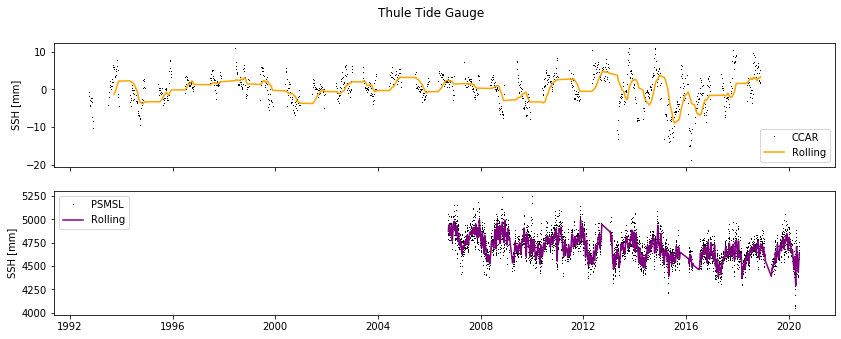

In [19]:
tideForecast(ccarArray[4], tideArray[5], 'Thule')

Trend = -16.93 mm/yr
                            OLS Regression Results                            
Dep. Variable:                    SSH   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     974.3
Date:                Thu, 06 Aug 2020   Prob (F-statistic):          1.78e-193
Time:                        13:56:10   Log-Likelihood:                -27664.
No. Observations:                4422   AIC:                         5.533e+04
Df Residuals:                    4420   BIC:                         5.534e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4793.9514      3.79

Text(0.5, 0.98, 'Thule')

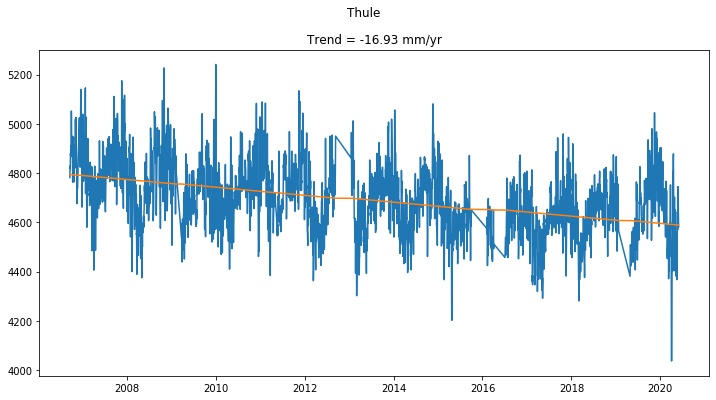

In [21]:
res = calc_OLS_tides(tideArray[5], 'SSH')
trend = res.params.x1 *365
print(f"Trend = {trend * 1:.2f} mm/yr")
print(res.summary())

fig, ax = plt.subplots(1, 1, figsize=(12,6));

ax.plot(tideArray[5]['SSH'].dropna().index, tideArray[5]['SSH'].dropna().values, label='trend')
ax.plot(tideArray[5]['SSH'].dropna().index, [res.params.x1 * i + res.params.const for i in np.arange(len(tideArray[5]['SSH'].dropna()))])
ax.set_title(f"Trend = {trend * 1:.2f} mm/yr");
plt.suptitle(f"{'Thule' [-21:5]}")

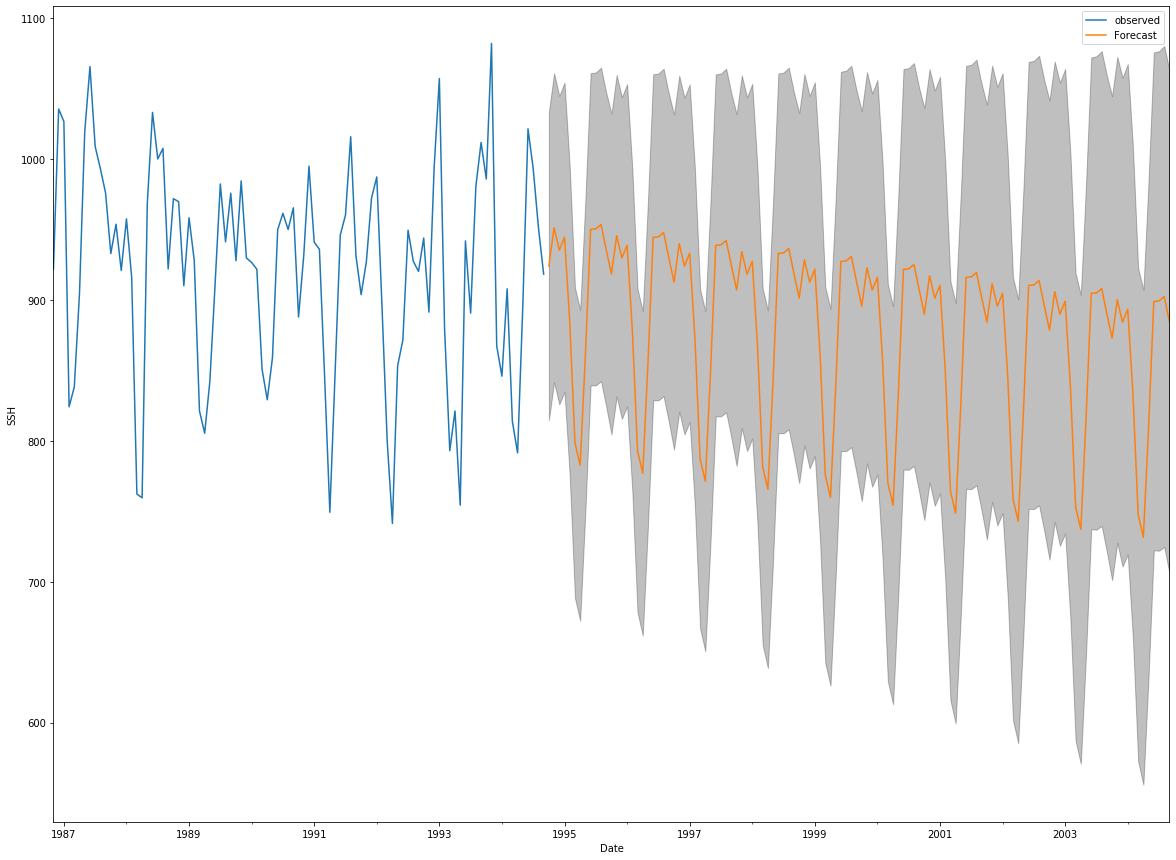

In [18]:
arima(tideArray[4], 120, (0, 1, 1), (0, 1, 1, 12))